In [108]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw4.ok')

Assignment: hw4
OK, version v1.14.20



# Homework 4: Trump, Twitter, and Text

## Due Date: Monday 03/02, 11:59 pm PST

Welcome to the fourth homework assignment of Data 100/200! In this assignment, we will work with Twitter data in order to analyze Donald Trump's tweets.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** below.

**Collaborators**: *list collaborators here*

In [109]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

### Score Breakdown

Question | Points
--- | ---
0 | 2
1 | 2
2 | 1
3 | 2
4a | 1
4b | 2
4c | 2
4d | 1
5a | 1
5b | 1
5c | 1
5d | 1
5e | 1
5f | 2
5g | 2
5h | 2
6a | 1
6b | 1
7a | 2
7b | 1
Total | 29

## Before we start ##
Before we actually analyze the tweets, you might find this article interesting. It contains some recent news about President Trump setting yet another Twitter record.
https://www.usatoday.com/story/news/politics/2019/10/01/donald-trump-sets-twitter-record-amid-impeachment-inquiry-over-ukraine/3828507002/

---
# Part 1: Importing the Data

We will use the `fetch_and_cache` utility to download the dataset. 

In [110]:
# Download the dataset
from ds100_utils import fetch_and_cache
data_url = 'http://www.ds100.org/fa19/assets/datasets/hw4-realdonaldtrump_tweets.json.zip'
file_name = 'hw4-realdonaldtrump_tweets.json.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Tue Feb 25 08:51:22 2020
MD5 hash of file: 664c6f85e94ea09e1507eedd7626adc5
Located at data/hw4-realdonaldtrump_tweets.json.zip


Now that we've downloaded the tweets, let's unzip them and load them into our notebook. Run the cell below to unzip and read tweets from the json file into a list named `all_tweets`.

In [111]:
# Unzip the dataset
my_zip = zipfile.ZipFile(dest_path, 'r')
with my_zip.open('hw4-realdonaldtrump_tweets.json', 'r') as f:
    all_tweets = json.load(f)

Here is what a typical tweet from `all_tweets` looks like:

In [112]:
from pprint import pprint # to get a more easily-readable view.
pprint(all_tweets[-1])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Oct 16 18:40:18 +0000 2018',
 'display_text_range': [0, 174],
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 52115,
 'favorited': False,
 'full_text': 'Just spoke with the Crown Prince of Saudi Arabia who totally '
              'denied any knowledge of what took place in their Turkish '
              'Consulate. He was with Secretary of State Mike Pompeo...',
 'geo': None,
 'id': 1052268011900555265,
 'id_str': '1052268011900555265',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 13493,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" '
           'rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'user': {'contributors_enabled': False,
  

## Question 0
Why might someone be interested in doing data analysis on the President’s tweets? Name one person or entity which might be interested in this kind of analysis. Then, give two reasons why a data analysis of the President's tweets might be interesting or useful for them. Answer in 2-3 sentences.
<!--
BEGIN QUESTION
name: q0
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

One of the President's rivals might be interested in doing so. With a data analysis of the President's tweets they might

1. have a better understading of President's policy focus in order to find some reasons to criticize him
1. make sure they themselves don't make the same mistake when their own rivals doing a data analysis to them

## Question 1

Construct a DataFrame called `trump` containing data from all the tweets stored in `all_tweets`. The index of the DataFrame should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created encoded as a datetime object. (Use `pd.to_datetime` to encode the timestamp.)
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

Finally, **the resulting DataFrame should be sorted by the index.**

**Warning:** *Some tweets will store the text in the `text` field and other will use the `full_text` field.*

**Hint: You might want to explicitly specify the columns and indices using** `pd.Dataframe()`.

<!--
BEGIN QUESTION
name: q1
points: 2
-->

In [113]:
with my_zip.open('hw4-realdonaldtrump_tweets.json', 'r') as f:
    trump = pd.read_json(f)
trump = trump[["id", "created_at", "source", "text", "full_text", "retweet_count"]] \
        .set_index("id") \
        .rename(columns = {"created_at":"time"})
trump['text'] = trump['text'].fillna(trump['full_text'])
trump = trump.drop(["full_text"], axis = 1)
# is actually default timestamp
trump.loc[:, "time"] = pd.to_datetime(trump.loc[:, "time"])

In [114]:
ok.grade("q1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 9
    Failed: 0
[ooooooooook] 100.0% passed



---
# Part 2: Tweet Source Analysis

In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

First let's examine the source field:

In [115]:
trump['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>'],
      dtype=object)

## Question 2

Notice how sources like "Twitter for Android" or "Instagram" are surrounded by HTML tags. In the cell below, clean up the `source` field by removing the HTML tags from each `source` entry.

**Hints:** 
* Use `trump['source'].str.replace` along with a regular expression.
* You may find it helpful to experiment with regular expressions at [regex101.com](https://regex101.com/).

<!--
BEGIN QUESTION
name: q2
points: 1
-->

In [116]:
## Uncomment and complete
trump['source'] = trump['source'].str.replace("<[^>]*>", "");

In [117]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



In the following plot, we see that there are two device types that are more commonly used than others.

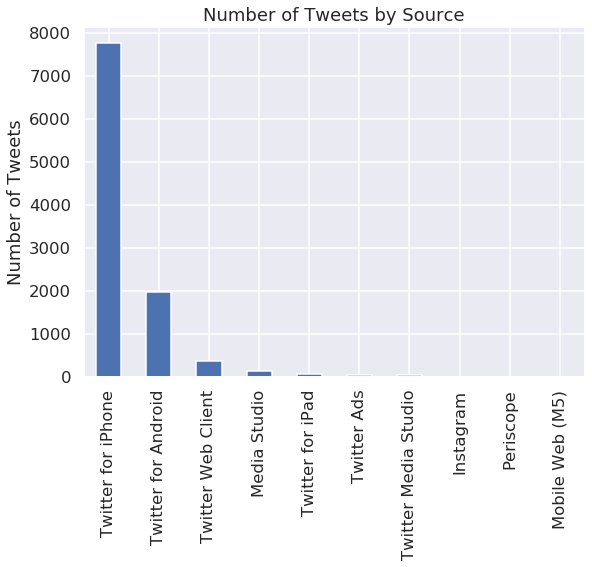

In [118]:
plt.figure(figsize=(8, 6))
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets by Source");

## Question 3

Now that we have cleaned up the `source` field, let's now look at which device Trump has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from this [link](https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years))

In [119]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

trump['year'] = trump['time'].apply(year_fraction)

Now, use `sns.distplot` to overlay the distributions of Trump's 2 most frequently used web technologies over the years. Your final plot should look similar to the plot below:

<img src="images/source_years_q3.png" width="600px" />

<!--
BEGIN QUESTION
name: q3
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

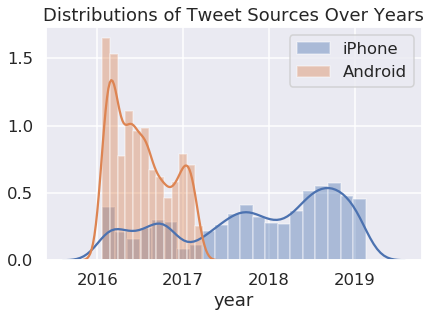

In [120]:
sns.distplot(trump[trump["source"]=="Twitter for iPhone"]["year"])
sns.distplot(trump[trump["source"]=="Twitter for Android"]["year"])
plt.xlabel("year")
plt.title('Distributions of Tweet Sources Over Years')
plt.legend(['iPhone','Android'])
plt.yticks(ticks=np.arange(0.0, 1.7, 0.5))
plt.xticks(ticks=np.arange(2016, 2020, 1));

## Question 4


Is there a difference between Trump's tweet behavior across these devices? We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android device come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets) (notice the `+0000` in the first few tweets).

In [121]:
for tweet in all_tweets[:3]:
    print(tweet['created_at'])

Wed Oct 12 14:00:48 +0000 2016
Wed Oct 12 13:46:43 +0000 2016
Wed Oct 12 12:59:05 +0000 2016


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [122]:
trump['est_time'] = (
    trump['time'].dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,year,est_time
id,,,,,,
786204978629185536,2016-10-12 14:00:48+00:00,Twitter for iPhone,PAY TO PLAY POLITICS. \n#CrookedHillary https://t.co/wjsl8ITVvk,24915,2016.778689,2016-10-12 09:00:48-05:00
786201435486781440,2016-10-12 13:46:43+00:00,Twitter for iPhone,Very little pick-up by the dishonest media of incredible information provided by WikiLeaks. So dishonest! Rigged system!,22609,2016.778689,2016-10-12 08:46:43-05:00
786189446274248704,2016-10-12 12:59:05+00:00,Twitter for Android,Crooked Hillary Clinton likes to talk about the things she will do but she has been there for 30 years - why didn't she do them?,18329,2016.778689,2016-10-12 07:59:05-05:00
786054986534969344,2016-10-12 04:04:47+00:00,Twitter for iPhone,Thank you Florida- a MOVEMENT that has never been seen before and will never be seen again. Lets get out &amp;… https://t.co/t9XM9wFDZI,18789,2016.778689,2016-10-11 23:04:47-05:00
786007502639038464,2016-10-12 00:56:06+00:00,Twitter for iPhone,"Join me Thursday in Florida &amp; Ohio!\nWest Palm Beach, FL at noon:\nhttps://t.co/jwbZnQhxg9\nCincinnati, OH this 7:30pm:\nhttps://t.co/5w2UhalPIx",7761,2016.778689,2016-10-11 19:56:06-05:00


### Question 4a

Add a column called `hour` to the `trump` table which contains the hour of the day as floating point number computed by:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$

* **Hint:** See the cell above for an example of working with [dt accessors](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#basics-dt-accessors). You should use the `est_time` column to calculate the hour.

<!--
BEGIN QUESTION
name: q4a
points: 1
-->

In [123]:
trump['hour'] = trump['est_time'].dt.hour + trump['time'].dt.minute/60 + trump['time'].dt.second/3600

In [124]:
ok.grade("q4a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 4b

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that Trump tweets on each device for the 2 most commonly used devices.  Your final plot should look similar to the following:

<img src="images/device_hour4b.png" width="600px" />

<!--
BEGIN QUESTION
name: q4b
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

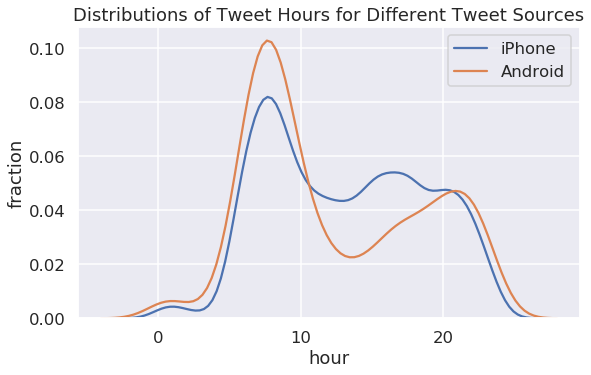

In [237]:
### make your plot here
plt.figure(figsize=(8, 5))
sns.distplot(trump[trump["source"] == "Twitter for iPhone"]["hour"], hist = False, label = 'iPhone')
sns.distplot(trump[trump["source"] == "Twitter for Android"]["hour"], hist = False, label = 'Android')
plt.xlabel("hour")
plt.ylabel("fraction")
plt.title('Distributions of Tweet Hours for Different Tweet Sources')
plt.xticks(ticks=np.arange(0, 24, 10));

### Question 4c

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017.

Let's see if this information significantly changes our plot. Create a figure similar to your figure from question 4b, but this time, only use tweets that were tweeted before 2017. Your plot should look similar to the following:

<img src="images/device_hour4c.png" width="600px" />

<!--
BEGIN QUESTION
name: q4c
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

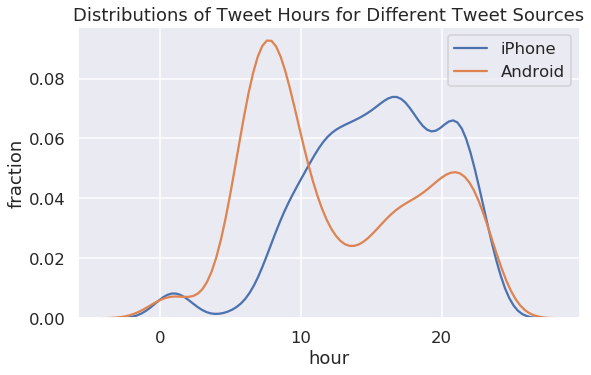

In [126]:
### make your plot here
plt.figure(figsize=(8, 5))
sns.distplot(trump[(trump["source"] == "Twitter for iPhone") & (trump["year"] < 2017)]["hour"], hist = False, label = 'iPhone')
sns.distplot(trump[(trump["source"] == "Twitter for Android") & (trump["year"] < 2017)]["hour"], hist = False, label = 'Android')
plt.xlabel("hour")
plt.ylabel("fraction")
plt.title('Distributions of Tweet Hours for Different Tweet Sources')
plt.xticks(ticks=np.arange(0, 24, 10));

### Question 4d

During the campaign, it was theorized that Donald Trump's tweets from Android devices were written by him personally, and the tweets from iPhones were from his staff. Does your figure give support to this theory? What kinds of additional analysis could help support or reject this claim?

<!--
BEGIN QUESTION
name: q4d
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

**Does your figure give support to this theory?**

Yes, it does. As we can see, tweets time from android devices are consistent before and after 2017, as contrast to iPhone.

**What kinds of additional analysis could help support or reject this claim?**

To help support, find enough cases that multiple tweets are published from different devices at roughly the same time. Show the otherwise to help reject.

---
# Part 3: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [127]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



As you can see, the lexicon contains emojis too! Each row contains a word and the *polarity* of that word, measuring how positive or negative the word is.

## Question 5

The creators of VADER describe the tool’s assessment of polarity, or “compound score,” in the following way:

“The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.”

As you can see, VADER doesn't "read" sentences, but works by parsing sentences into words assigning a preset generalized score from their testing sets to each word separately. 

VADER relies on humans to stabilize its scoring. The creators use Amazon Mechanical Turk, a crowdsourcing survey platform, to train its model. Its training set of data consists of a small corpus of tweets, New York Times editorials and news articles, Rotten Tomatoes reviews, and Amazon product reviews, tokenized using the natural language toolkit (NLTK). Each word in each dataset was reviewed and rated by at least 20 trained individuals who had signed up to work on these tasks through Mechanical Turk. 

### Question 5a

Given the above information about how VADER works, name one advantage and one disadvantage of using VADER in our analysis. 

<!--
BEGIN QUESTION
name: q5a
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

Advantage: fast and easy to use.

Disadvantage: might not be accurate under certain circumstances (see below).

### Question 5b
Are there circumstances (e.g. certain kinds of language or data) when you might not want to use VADER? Please answer "Yes," or "No," and provide 1 reason for your answer. 

<!--
BEGIN QUESTION
name: q5b
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

Yes. Certain sentences including logic computation like 'not' can inverse/change the sentiment of the whole sentence which cannot be measured via summing words together.

### Question 5c

Read `vader_lexicon.txt` into a DataFrame called `sent`. The index of the DataFrame should be the words in the lexicon. `sent` should have one column named `polarity`, storing the polarity of each word.

* **Hint:** The `pd.read_csv` function may help here. Since the file is tab-separated, be sure to set `sep='\t'` in your call to `pd.read_csv`. 

<!--
BEGIN QUESTION
name: q5c
points: 1
-->

In [128]:
sent = pd.read_csv("vader_lexicon.txt", sep = '\t', header = None) \
         .iloc[:, [0,1]]
sent.columns = ['index', 'polarity']
sent = sent.set_index('index')
sent.head()

,polarity
index,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [129]:
ok.grade("q5c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5d

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DataFrame to be the lowercased text of each tweet.

<!--
BEGIN QUESTION
name: q5d
points: 1
-->

In [130]:
trump['text'] = trump['text'].str.lower()
trump.head()

,time,source,text,retweet_count,year,est_time,hour
id,,,,,,,
786204978629185536,2016-10-12 14:00:48+00:00,Twitter for iPhone,pay to play politics. \n#crookedhillary https://t.co/wjsl8itvvk,24915,2016.778689,2016-10-12 09:00:48-05:00,9.013333
786201435486781440,2016-10-12 13:46:43+00:00,Twitter for iPhone,very little pick-up by the dishonest media of incredible information provided by wikileaks. so dishonest! rigged system!,22609,2016.778689,2016-10-12 08:46:43-05:00,8.778611
786189446274248704,2016-10-12 12:59:05+00:00,Twitter for Android,crooked hillary clinton likes to talk about the things she will do but she has been there for 30 years - why didn't she do them?,18329,2016.778689,2016-10-12 07:59:05-05:00,7.984722
786054986534969344,2016-10-12 04:04:47+00:00,Twitter for iPhone,thank you florida- a movement that has never been seen before and will never be seen again. lets get out &amp;… https://t.co/t9xm9wfdzi,18789,2016.778689,2016-10-11 23:04:47-05:00,23.079722
786007502639038464,2016-10-12 00:56:06+00:00,Twitter for iPhone,"join me thursday in florida &amp; ohio!\nwest palm beach, fl at noon:\nhttps://t.co/jwbznqhxg9\ncincinnati, oh this 7:30pm:\nhttps://t.co/5w2uhalpix",7761,2016.778689,2016-10-11 19:56:06-05:00,19.935000


In [131]:
ok.grade("q5d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5e

Now, let's get rid of punctuation since it will cause us to fail to match words. Create a new column called `no_punc` in the `trump` DataFrame to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be *any character that isn't a Unicode word character or a whitespace character*. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

<!--
BEGIN QUESTION
name: q5e
points: 1
-->

In [261]:
# Save your regex in punct_re
punct_re = r'[^\w\s]'
trump['no_punc'] = trump['text'].str.replace(punct_re, ' ')

In [262]:
ok.grade("q5e");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 10
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5f

Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>894661651760377856</th>
      <td>0</td>
      <td>i</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>1</td>
      <td>think</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>2</td>
      <td>senator</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>3</td>
      <td>blumenthal</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>4</td>
      <td>should</td>
    </tr>
  </tbody>
</table>

**Note that your DataFrame may look different from the one above.** However, you can double check that your tweet with ID `894661651760377856` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

As usual, try to avoid using any for loops. Our solution uses a chain of 5 methods on the `trump` DataFrame, albeit using some rather advanced Pandas hacking.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.

* **Hint 3:** Try looking at the `level` parameter of the `reset_index` method.

<!--
BEGIN QUESTION
name: q5f
points: 2
-->

In [177]:
tidy_format = trump['no_punc'].str.split(expand = True).stack().to_frame().reset_index(level = 1)
tidy_format.columns = ['num', 'word']

In [178]:
ok.grade("q5f");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5g

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

Add a `polarity` column to the `trump` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text of the tweet.

**Hints:** 
* You will need to merge the `tidy_format` and `sent` tables and group the final answer.
* If certain words are not found in the `sent` table, set their polarities to 0.

<!--
BEGIN QUESTION
name: q5g
points: 2
-->

In [228]:
tidy_format["id"] = tidy_format.index
q5g_merged = pd.merge(tidy_format, sent, how = "left", left_on = "word", right_on = "index")
q5g_merged["polarity"] = q5g_merged["polarity"].fillna(0)
trump['polarity'] = q5g_merged.groupby("id").agg({"polarity":"sum"})

In [229]:
ok.grade("q5g");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 6
    Failed: 0
[ooooooooook] 100.0% passed



Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [230]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   the trump portrait of an unsustainable border crisis is dead on. “in the last two years, ice officers made 266,000 arrests of aliens with criminal records, including those charged or convicted of 100,000 assaults, 30,000 sex crimes &amp; 4000 violent killings.” america’s southern....

   it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!

   the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!

   ...this evil anti-semitic attack is an assault on humanity. it will take all of us working together to extract the poison of an

In [231]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!

   congratulations to a truly great football team, the clemson tigers, on an incredible win last night against a powerful alabama team. a big win also for the great state of south carolina. look forward to seeing the team, and their brilliant coach, for the second time at the w.h.

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new

## Question 5h

Read the 5 most positive and 5 most negative tweets. Do you think these tweets are accurately represented by their polarity scores?

<!--
BEGIN QUESTION
name: q5h
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

Yes, I do.

## Question 6

Now, let's try looking at the distributions of sentiments for tweets containing certain keywords.

### Question 6a

In the cell below, create a single plot showing both the distribution of tweet sentiments for tweets containing `nytimes`, as well as the distribution of tweet sentiments for tweets containing `fox`.

Be sure to label your axes and provide a title and legend. Be sure to use different colors for `fox` and `nytimes`.

<!--
BEGIN QUESTION
name: q6a
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

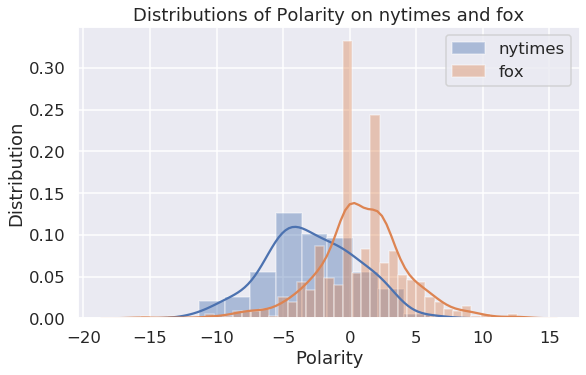

In [240]:
plt.figure(figsize=(8, 5))
sns.distplot(trump[trump["text"].str.contains("nytimes")]["polarity"], label = 'nytimes')
sns.distplot(trump[trump["text"].str.contains("fox")]["polarity"], label = 'fox')
plt.xlabel("Polarity")
plt.ylabel("Distribution")
plt.title('Distributions of Polarity on nytimes and fox')
plt.legend(['nytimes','fox']);

### Question 6b
Comment on what you observe in the plot above. Can you find another pair of keywords that lead to interesting plots? Describe what makes the plots interesting. (If you modify your code in 6a, remember to change the words back to `nytimes` and `fox` before submitting for grading).

<!--
BEGIN QUESTION
name: q6b
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

**Comment on what you observe in the plot above.**

D. Trump's twitters generally have a negative attitude against NYTimes, and a medorate one against Fox.

**Can you find another pair of keywords that lead to interesting plots? Describe what makes the plots interesting.**

keys: "love - like - hate" shows that the sentiment method is generally precise

keys: "japan - europe - china - russia" shows that Trump's twitters like Japan over Europe over China over Russia

## Question 7

Now, let's see whether there's a difference in sentiment for tweets with hashtags and those without.

### Question 7a
First, we'll need to write some regex that can detect whether a tweet contains a hashtag or a link. We say that:

- A tweet is a retweet if it has the string 'rt' anywhere in the tweet if it is preceeded and followed by a non-word character (the start and end of the string count as non-word characters).
- A tweet has a hashtag if it has the character '#' anywhere in the tweet followed by a letter.
- A tweet contains a link or a picture if it has `http` anywhere in the tweet

(You can check out Trump's Twitter for why these criteria are true).

In the cell below, assign `rt_re` to a regex pattern that identifies retweets and `hash_link_re` to a regex pattern that identifies tweets with hashtags or links.

**Hints**: 
- Be sure to precede your regex pattern with `r` to make it a raw string (Ex: `r'pattern'`). To find out more, you can read the first paragraph of the [documentation](https://docs.python.org/2/library/re.html).
- You may find using regex word boundaries helpful for one of your patterns. 

<!--
BEGIN QUESTION
name: q7a
points: 2
-->

In [257]:
rt_re = r'\Wrt\W|^rt\W|\Wrt$|^rt$'
hash_link_re = r'#\w|http'

In [258]:
ok.grade("q7a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 16
    Failed: 0
[ooooooooook] 100.0% passed



### Question 7b
Let's see whether there's a difference in sentiments for tweets with hashtags/links and those without. 

Run the cell below to see a distribution of tweet sentiments based on whether a tweet contains a hashtag or link.

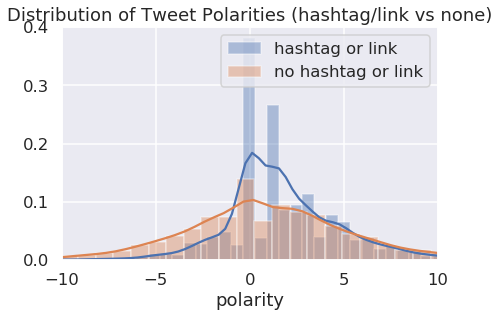

In [265]:
sns.distplot(trump[trump['text'].str.contains(hash_link_re)]['polarity'],label='hashtag or link');
sns.distplot(trump[~trump['text'].str.contains(hash_link_re)]['polarity'],label='no hashtag or link');
plt.xlim(-10, 10);
plt.ylim(0, 0.4);
plt.title('Distribution of Tweet Polarities (hashtag/link vs none)');
plt.legend();

What do you notice about the distributions? Answer in 1-2 sentences.

<!--
BEGIN QUESTION
name: q7b
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

D. Trump's hashtaged/linked twitters generally have positive sentiments, while  unhashtaged/unlinked generally have moderate sentiments.

## Congratulations! You have finished Homework 4!##

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 11 EXPORTED QUESTIONS -->

In [ ]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('hw4.ipynb', 'hw4.pdf')
ok.submit()